<a href="https://www.kaggle.com/code/marwantosolve/svm-mnist-phase2?scriptVersionId=213704181" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Install the essential libraries
!pip install cvxopt
!pip install idx2numpy

# Import the essential libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 85.2 MB/s eta 0:00:00:00:01:01
  Preparing metadata (setup.py) ... done
  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7904 sha256=307f65aa58a5bd821372b5ba6243203fbcca09ad61802f2ffbef6b7ed17c7c0e
  Stored in directory: /root/.cache/pip/wheels/e0/f4/e7/643fc5f932ec2ff92997f43f007660feb23f948aa8486f1107
Successfully built idx2numpy
/kaggle/input/mnist-dataset/train-images.idx3-ubyte
/kaggle/input/mnist-dataset/t10k-labels.idx1-ubyte
/kaggle/input/mnist-dataset/t10k-images.idx3-ubyte
/kaggle/input/mnist-dataset/train-labels.idx1-ubyte
/kaggle/input/mnist-dataset/t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte
/kaggle/input/mnist-dataset/t10k-images-idx3-ubyte/t10k-images-idx3-ubyte
/kaggle/input/mnist-dataset/train-labels-idx1-ubyte/train-labels-idx1-ubyte
/kaggle/input/mnist-dataset/train-images-idx3-ubyte/train-images-idx3-ubyte


In [3]:
# Import the essential libraries
import idx2numpy

# Load MNIST dataset     
X_train = '/kaggle/input/mnist-dataset/train-images.idx3-ubyte'
y_train = '/kaggle/input/mnist-dataset/train-labels.idx1-ubyte'
X_test = '/kaggle/input/mnist-dataset/t10k-images.idx3-ubyte'
y_test = '/kaggle/input/mnist-dataset/t10k-labels.idx1-ubyte'

X_train = idx2numpy.convert_from_file(X_train)
y_train = idx2numpy.convert_from_file(y_train)
X_test = idx2numpy.convert_from_file(X_test)
y_test = idx2numpy.convert_from_file(y_test)

# Flatten the images
X_train = X_train.reshape(-1, 28 * 28)
X_test = X_test.reshape(-1, 28 * 28)

# Normalize the data
X_train = X_train / 255.0
X_test = X_test / 255.0

In [4]:
# Import the essential libraries
from cvxopt import matrix, solvers

def train_binary_svm(X, y, C=1.0):
    """
    Train a binary SVM using quadratic programming.
    """
    n_samples, n_features = X.shape
    K = np.dot(X, X.T)  # Linear kernel
    P = matrix(np.outer(y, y) * K)
    q = matrix(-np.ones(n_samples))
    G = matrix(np.vstack((-np.eye(n_samples), np.eye(n_samples))))
    h = matrix(np.hstack((np.zeros(n_samples), np.ones(n_samples) * C)))
    A = matrix(y, (1, n_samples), 'd')
    b = matrix(0.0)
    
    # Solve QP problem
    solvers.options['show_progress'] = False
    solution = solvers.qp(P, q, G, h, A, b)
    alpha = np.ravel(solution['x'])
    
    # Compute weights and bias
    w = np.sum(alpha[:, None] * y[:, None] * X, axis=0)
    sv = alpha > 1e-5  # Support vectors
    b = np.mean(y[sv] - np.dot(X[sv], w))
    return w, b


def train_ovo_svm_in_batches(X, y, batch_size=2000, C=1.0):
    """
    Train One-vs-One SVM in mini-batches for all class pairs.
    """
    classes = np.unique(y)
    classifiers = {}
    
    for i, class1 in enumerate(classes):
        for j, class2 in enumerate(classes):
            if j <= i:
                continue  # Avoid duplicate pairs
            
            # Filter data for the two classes
            indices = (y == class1) | (y == class2)
            X_pair, y_pair = X[indices], y[indices]
            
            # Ensure NumPy arrays for batch processing
            X_pair = np.array(X_pair)
            y_pair = np.array(y_pair)
            
            # Convert labels to +1 and -1 for binary classification
            y_pair = np.where(y_pair == class1, -1, 1)
            
            # Train in batches
            n_samples = len(y_pair)
            indices_all = np.arange(n_samples)
            np.random.shuffle(indices_all)
            
            print(f"Training SVM for classes {class1} vs {class2}...")
            classifiers[(class1, class2)] = []
            for start in range(0, n_samples, batch_size):
                end = min(start + batch_size, n_samples)
                batch_indices = indices_all[start:end]
                X_batch, y_batch = X_pair[batch_indices], y_pair[batch_indices]
                
                w, b = train_binary_svm(X_batch, y_batch, C)
                classifiers[(class1, class2)].append((w, b))
    
    return classifiers

def predict_ovo_svm_in_batches(X, classifiers):
    """
    Predict the class of each sample using One-vs-One SVM with batch-trained classifiers.
    """
    n_samples = X.shape[0]
    votes = np.zeros((n_samples, 10))  # One vote counter for each class (10 total)
    
    for (class1, class2), models in classifiers.items():
        for w, b in models:
            # Decision function for this pair
            decision = np.dot(X, w) + b
            predictions = np.where(decision >= 0, class2, class1)
            
            # Increment votes for each predicted class
            for i, pred in enumerate(predictions):
                votes[i, pred] += 1
    
    # Final prediction is the class with the most votes
    return np.argmax(votes, axis=1)

In [5]:
# Train SVM in batches using One-vs-One strategy
batch_size = 2000
C = 1.0
classifiers = train_ovo_svm_in_batches(X_train, y_train, batch_size=batch_size, C=C)

# Predict on test data
y_pred = predict_ovo_svm_in_batches(X_test, classifiers)

Training SVM for classes 0 vs 1...
Training SVM for classes 0 vs 2...
Training SVM for classes 0 vs 3...
Training SVM for classes 0 vs 4...
Training SVM for classes 0 vs 5...
Training SVM for classes 0 vs 6...
Training SVM for classes 0 vs 7...
Training SVM for classes 0 vs 8...
Training SVM for classes 0 vs 9...
Training SVM for classes 1 vs 2...
Training SVM for classes 1 vs 3...
Training SVM for classes 1 vs 4...
Training SVM for classes 1 vs 5...
Training SVM for classes 1 vs 6...
Training SVM for classes 1 vs 7...
Training SVM for classes 1 vs 8...
Training SVM for classes 1 vs 9...
Training SVM for classes 2 vs 3...
Training SVM for classes 2 vs 4...
Training SVM for classes 2 vs 5...
Training SVM for classes 2 vs 6...
Training SVM for classes 2 vs 7...
Training SVM for classes 2 vs 8...
Training SVM for classes 2 vs 9...
Training SVM for classes 3 vs 4...
Training SVM for classes 3 vs 5...
Training SVM for classes 3 vs 6...
Training SVM for classes 3 vs 7...
Training SVM for cla

In [6]:
# Import the essential libraries
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# Evaluate the results
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(confusion_matrix(y_test, y_pred))

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

[[ 968    0    1    1    0    3    5    1    1    0]
 [   0 1124    2    2    0    1    2    1    3    0]
 [   9   12  945   21    9    0    8   13   12    3]
 [   1    2    9  967    0    5    3   12    8    3]
 [   1    1    6    1  936    0    7    6    2   22]
 [  10   11    4   81    5  742   14    4   16    5]
 [   8    3    7    1    2   11  921    2    3    0]
 [   2    9   17    3    3    0    0  984    2    8]
 [   5   22    5   40    7   17    9   15  849    5]
 [   8    8    2   12   23    3    1   38    2  912]]
Accuracy: 0.93
Precision: 0.94
Recall: 0.93
F1 Score: 0.93


Training SVM on 2D data (PCA reduced)...
Training SVM for classes 0 vs 1...
Training SVM for classes 0 vs 2...
Training SVM for classes 0 vs 3...
Training SVM for classes 0 vs 4...
Training SVM for classes 0 vs 5...
Training SVM for classes 0 vs 6...
Training SVM for classes 0 vs 7...
Training SVM for classes 0 vs 8...
Training SVM for classes 0 vs 9...
Training SVM for classes 1 vs 2...
Training SVM for classes 1 vs 3...
Training SVM for classes 1 vs 4...
Training SVM for classes 1 vs 5...
Training SVM for classes 1 vs 6...
Training SVM for classes 1 vs 7...
Training SVM for classes 1 vs 8...
Training SVM for classes 1 vs 9...
Training SVM for classes 2 vs 3...
Training SVM for classes 2 vs 4...
Training SVM for classes 2 vs 5...
Training SVM for classes 2 vs 6...
Training SVM for classes 2 vs 7...
Training SVM for classes 2 vs 8...
Training SVM for classes 2 vs 9...
Training SVM for classes 3 vs 4...
Training SVM for classes 3 vs 5...
Training SVM for classes 3 vs 6...
Training SVM f

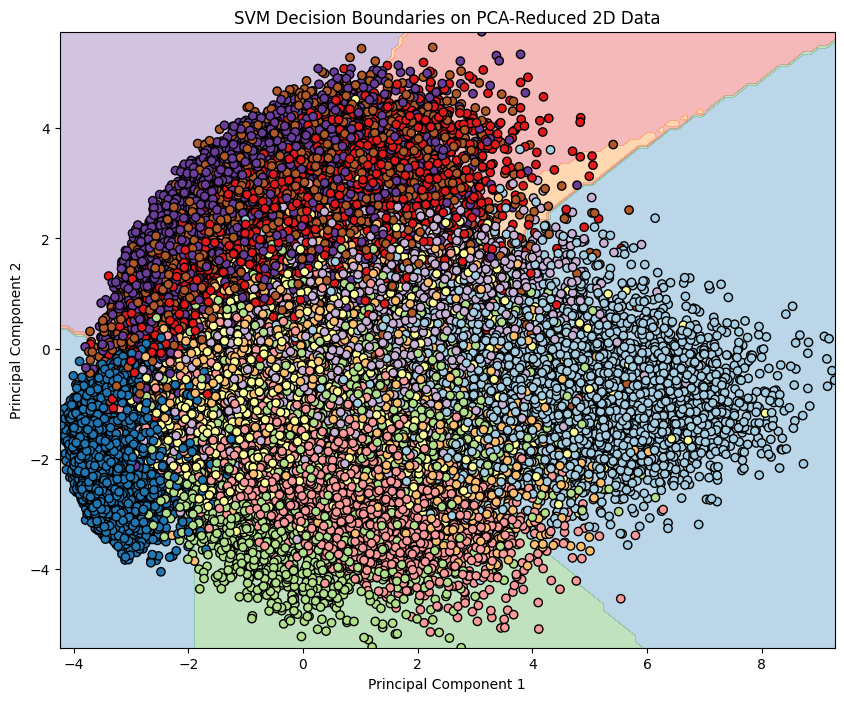

In [7]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Step 1: Apply PCA to reduce the dataset to 2 dimensions
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train)  # Reduce training data to 2D
X_test_2d = pca.transform(X_test)        # Reduce test data to 2D

# Step 2: Train SVM in batches on the reduced 2D data (One-vs-One strategy)
batch_size = 2000
C = 1.0
print("Training SVM on 2D data (PCA reduced)...")
classifiers_2d = train_ovo_svm_in_batches(X_train_2d, y_train, batch_size=batch_size, C=C)

# Step 3: Generate grid points for plotting the decision boundary
xx, yy = np.meshgrid(np.linspace(X_train_2d[:, 0].min(), X_train_2d[:, 0].max(), 100),
                     np.linspace(X_train_2d[:, 1].min(), X_train_2d[:, 1].max(), 100))
grid = np.c_[xx.ravel(), yy.ravel()]

# Step 4: Predict on the grid using OvO classifiers
def predict_ovo_grid(X, classifiers):
    """
    Predict class labels for a grid of points using One-vs-One classifiers.
    """
    n_samples = X.shape[0]
    votes = np.zeros((n_samples, 10))  # Voting for 10 classes

    for (class1, class2), models in classifiers.items():
        for w, b in models:
            decision = np.dot(X, w) + b  # Linear decision function
            predictions = np.where(decision >= 0, class2, class1)
            for i, pred in enumerate(predictions):
                votes[i, pred] += 1
    
    return np.argmax(votes, axis=1)

# Predict on the grid
grid_predictions = predict_ovo_grid(grid, classifiers_2d)
grid_predictions = grid_predictions.reshape(xx.shape)

# Step 5: Plot decision boundaries and training points
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, grid_predictions, alpha=0.3, cmap=plt.cm.Paired)
plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, cmap=plt.cm.Paired, edgecolors='k')
plt.title("SVM Decision Boundaries on PCA-Reduced 2D Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

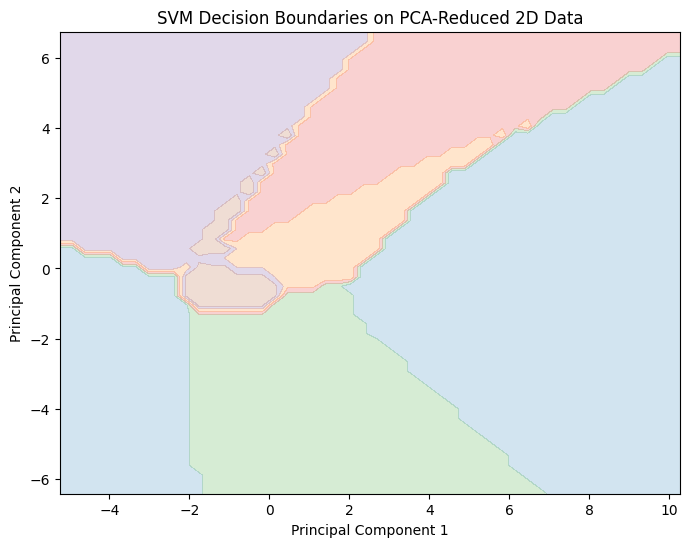

In [8]:
# Step 3: Generate a coarser grid for plotting the decision boundary
xx, yy = np.meshgrid(np.linspace(X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1, 50),
                     np.linspace(X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1, 50))
grid = np.c_[xx.ravel(), yy.ravel()]

# Step 4: Predict class labels on the grid
grid_predictions = predict_ovo_grid(grid, classifiers_2d).reshape(xx.shape)

# Step 5: Plot decision boundaries and a subsample of training points
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, grid_predictions, alpha=0.2, cmap=plt.cm.Paired)
plt.title("SVM Decision Boundaries on PCA-Reduced 2D Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

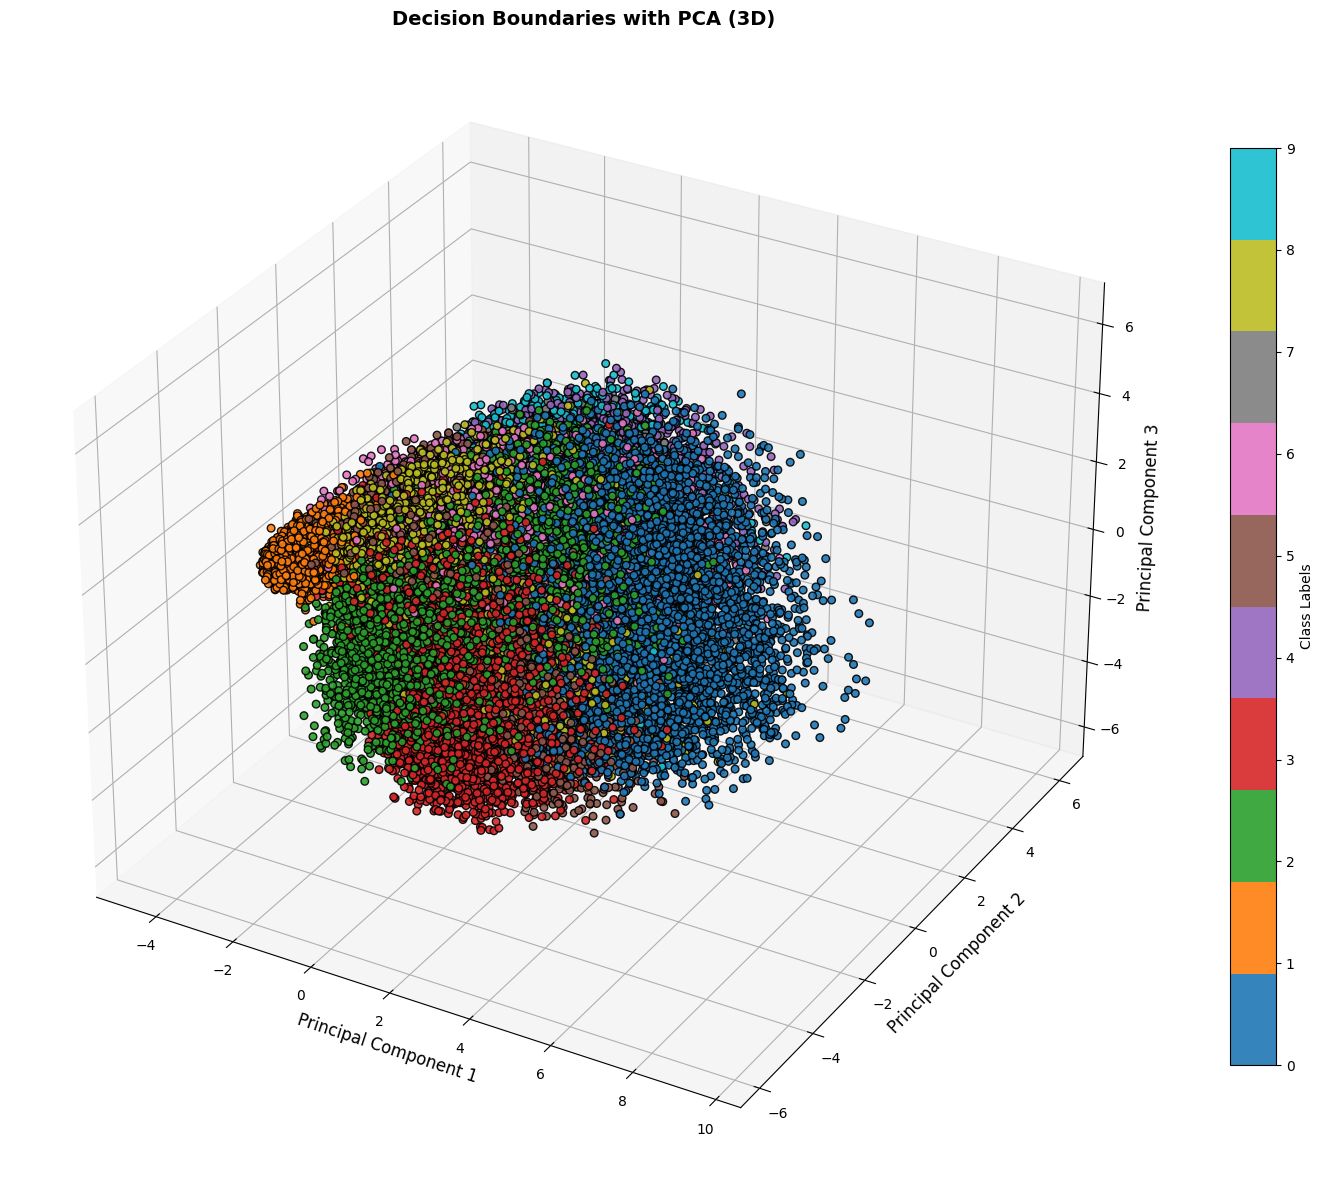

In [11]:
# Import necessary libraries
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D

# Function to apply PCA and plot decision boundaries in 3D
def apply_pca_and_plot_3d(X_train, y_train, classifiers, n_classes=10, n_components=3):
    """
    Apply PCA to reduce dimensionality and visualize decision boundaries in 3D.
    """
    # Apply PCA
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)

    # Generate a 3D grid for visualization (increased resolution)
    x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
    y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
    z_min, z_max = X_train_pca[:, 2].min() - 1, X_train_pca[:, 2].max() + 1
    x_vals = np.linspace(x_min, x_max, 100)
    y_vals = np.linspace(y_min, y_max, 100)
    z_vals = np.linspace(z_min, z_max, 100)
    xx, yy, zz = np.meshgrid(x_vals, y_vals, z_vals)
    grid_points = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]

    # Predict on the grid points
    grid_votes = np.zeros((grid_points.shape[0], n_classes))  # Votes for each class
    for (class1, class2), models in classifiers.items():
        for w, b in models:
            decision = np.dot(grid_points, w[:3]) + b
            predictions = np.where(decision >= 0, class2, class1)
            for i, pred in enumerate(predictions):
                grid_votes[i, pred] += 1
    grid_predictions = np.argmax(grid_votes, axis=1).reshape(xx.shape)

    # Define a color map
    cmap = ListedColormap(plt.colormaps['tab10'].colors[:n_classes])

    # Plot 3D decision boundaries
    fig = plt.figure(figsize=(15, 12))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], X_train_pca[:, 2],
                         c=y_train, cmap=cmap, s=30, edgecolor='k', alpha=0.9)
    ax.set_title("Decision Boundaries with PCA (3D)", fontsize=14, fontweight='bold')
    ax.set_xlabel("Principal Component 1", fontsize=12)
    ax.set_ylabel("Principal Component 2", fontsize=12)
    ax.set_zlabel("Principal Component 3", fontsize=12)
    ax.grid(True, linestyle='--', linewidth=0.5)
    fig.colorbar(scatter, ticks=np.arange(n_classes), label="Class Labels", shrink=0.8)

    # Fine-tune axis limits
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([y_min, y_max])
    ax.set_zlim([z_min, z_max])

    plt.tight_layout()
    plt.show()

# Call the function to visualize in 3D
apply_pca_and_plot_3d(X_train, y_train, classifiers)
